In [1]:
import os
import cv2

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def load_data(images_path, masks_path):
    images = []
    masks = []
    
    for img_name in os.listdir(images_path):
        img = cv2.imread(os.path.join(images_path, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))  # Изменяем размер
        img = img / 255.0  # Нормализация
        images.append(img)

        mask_name = img_name
        mask = cv2.imread(os.path.join(masks_path, mask_name), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
        mask = (mask > 0).astype(np.float32)  # Бинаризация
        masks.append(mask)

    return np.array(images), np.array(masks)

In [3]:
def plot_results(original_images, true_masks, predicted_masks, num=5):
    plt.figure(figsize=(20, 13))

    for i in range(num):
        idx = np.random.randint(len(original_images))
        plt.subplot(4, num, i + 1)
        plt.imshow(original_images[idx], cmap="gray")
        plt.axis("off")
        plt.title("Image")

        plt.subplot(4, num, i + num + 1)
        plt.imshow(true_masks[idx], cmap="gray")
        plt.axis("off")
        plt.title("Original Mask")

        plt.subplot(4, num, i + 2 * num + 1)
        plt.imshow((predicted_masks[idx] > 0.5).astype(np.float32), cmap="gray")
        plt.axis("off")
        plt.title("Predicted Mask")
        
        plt.subplot(4, num, i + 3 * num + 1)
        plt.imshow(predicted_masks[idx] * original_images[idx], cmap="gray")
        plt.axis("off")
        plt.title("Predicted image")

    plt.show()

In [4]:
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))  # Изменяем размер
    img = img / 255.0  # Нормализация

    return np.array(img).reshape(1, 256, 256, 3)

In [5]:
def plot_result(original_image, predicted_mask1, predicted_mask2):
    plt.figure(figsize=(20, 80))

    plt.subplot(1, 5, 1)
    plt.imshow(original_image[0], cmap="gray")
    plt.axis("off")
    plt.title("Image")

    plt.subplot(1, 5, 2)
    plt.imshow((predicted_mask1 > 0.5).astype(np.float32), cmap="gray")
    plt.axis("off")
    plt.title("Predicted Mask ffnn")
    
    plt.subplot(1, 5, 3)
    plt.imshow((predicted_mask1 * original_image)[0], cmap="gray")
    plt.axis("off") 
    plt.title("Predicted image ffnn")

    plt.subplot(1, 5, 4)
    plt.imshow((predicted_mask2 > 0.5).astype(np.float32), cmap="gray")
    plt.axis("off")
    plt.title("Predicted Mask cond")
    
    plt.subplot(1, 5, 5)
    plt.imshow((predicted_mask2 * original_image)[0], cmap="gray")
    plt.axis("off")
    plt.title("Predicted image cond")

    plt.show()

In [6]:
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.6,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [7]:
X, Y = load_data("images_touching_extra", "labels_touching_extra")

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [9]:
def weighted_binary_crossentropy(weights):
    def loss(y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        bce = binary_crossentropy(y_true, y_pred)

        return tf.reduce_mean(bce * weights)
    return loss

In [10]:
model_fc = keras.Sequential([
    layers.Flatten(input_shape=(256, 256, 3)),
    layers.Dense(512, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256 * 256, activation='sigmoid'),  # Выход в виде плоского массива
    layers.Reshape((256, 256, 1))  # Обратное преобразование в сегментацию
])
model_fc.compile(optimizer='adam', loss=weighted_binary_crossentropy(0.8), metrics=['accuracy', 'precision'])

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
history = model_fc.fit(datagen.flow(X_train, Y_train, batch_size=8), 
            validation_data=(X_val, Y_val),
            epochs=30)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6104 - loss: 0.5236 - precision: 0.5738 - val_accuracy: 0.6788 - val_loss: 0.4958 - val_precision: 0.6824
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.6610 - loss: 0.4972 - precision: 0.6488 - val_accuracy: 0.6776 - val_loss: 0.4920 - val_precision: 0.6907
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6669 - loss: 0.4945 - precision: 0.6696 - val_accuracy: 0.6815 - val_loss: 0.4805 - val_precision: 0.6907
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.6717 - loss: 0.4866 - precision: 0.6724 - val_accuracy: 0.6778 - val_loss: 0.4825 - val_precision: 0.6872
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6689 - loss: 0.4919 - precision: 0.6700 - val_accuracy: 0.6814 - val_loss: 0.4798 - val_precision: 0.6956
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6719 - loss: 0.4885 - precision: 0.6776 - val_accuracy: 0.6825 - val_loss: 0.4807 - va

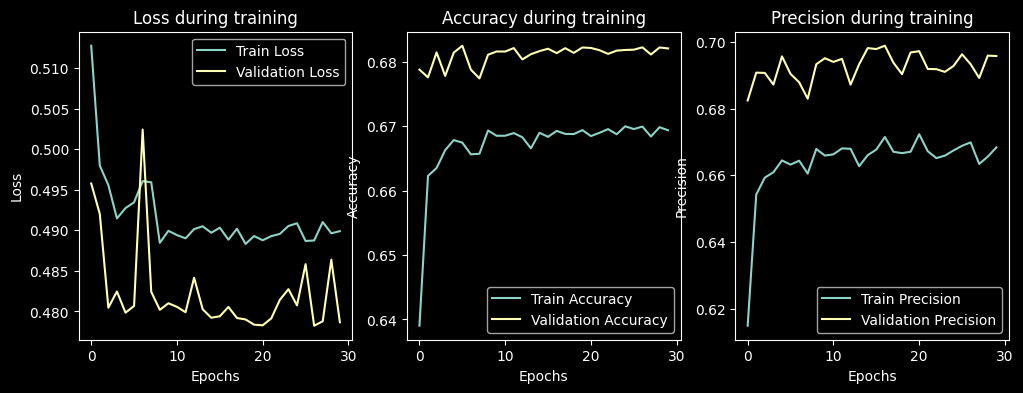

In [12]:
# График потерь
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# График точности
plt.subplot(1, 3, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision during training')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.show()

In [13]:
Y_pred_ffnn = model_fc.predict(X_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step


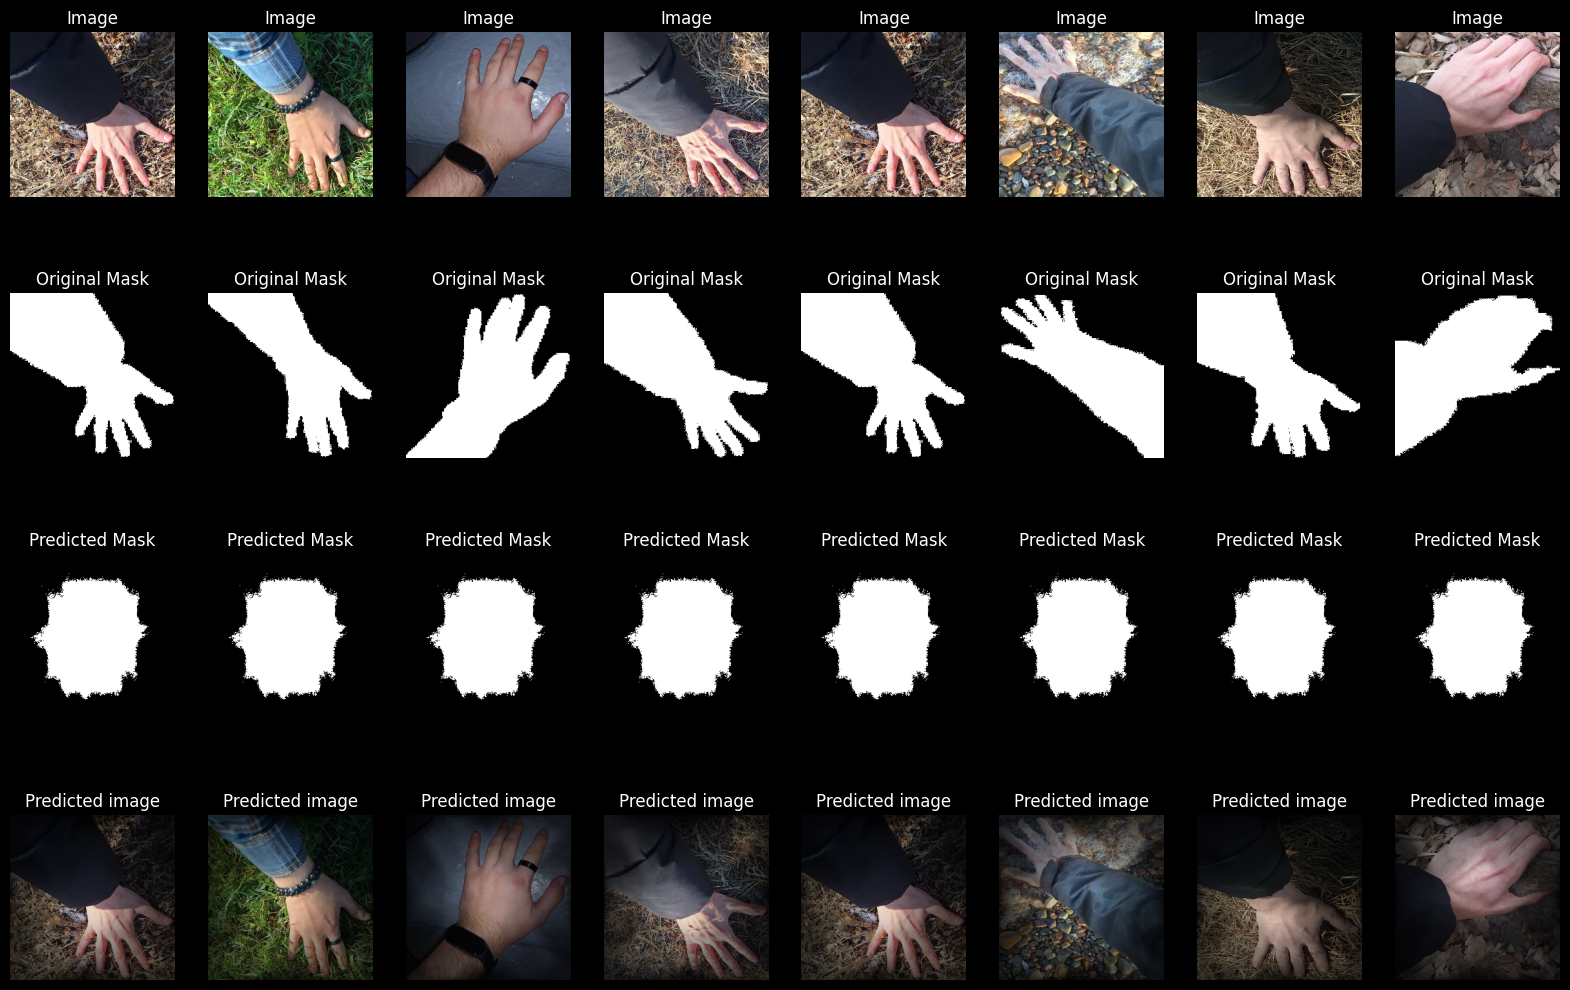

In [14]:
plot_results(X_val, Y_val, Y_pred_ffnn, num=8)

In [15]:
Y_pred = (Y_pred_ffnn > 0.5).astype(np.float32)
# Вычисление метрик
accuracy = np.mean(Y_pred.flatten() == Y_val.flatten())
precision = precision_score(Y_val.flatten(), Y_pred.flatten())
recall = recall_score(Y_val.flatten(), Y_pred.flatten())

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Accuracy: 0.6821, Precision: 0.6957, Recall: 0.5393


In [16]:
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Энергия спуска
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Декодирование
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

In [17]:
model_unet = unet_model((256, 256, 3))
model_unet.compile(optimizer='adam', loss=weighted_binary_crossentropy(0.5), metrics=['accuracy', 'precision'])

In [18]:
history = model_unet.fit(X_train, Y_train, batch_size=8, validation_data=(X_val, Y_val), epochs=15)

Epoch 1/15


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_8']. Received: the structure of inputs=*
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 450s 16s/step - accuracy: 0.5909 - loss: 0.3400 - precision: 0.5360 - val_accuracy: 0.6920 - val_loss: 0.2782 - val_precision: 0.6341
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 440s 17s/step - accuracy: 0.7547 - loss: 0.2630 - precision: 0.7254 - val_accuracy: 0.7333 - val_loss: 0.2552 - val_precision: 0.7424
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 410s 16s/step - accuracy: 0.7631 - loss: 0.2439 - precision: 0.7267 - val_accuracy: 0.7163 - val_loss: 0.2709 - val_precision: 0.6225
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 402s 16s/step - accuracy: 0.7610 - loss: 0.2390 - precision: 0.7010 - val_accuracy: 0.8008 - val_loss: 0.2296 - val_precision: 0.7130
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 398s 15s/step - accuracy: 0.7847 - loss: 0.2263 - precision: 0.7250 - val_accuracy: 0.8278 - val_loss: 0.1921 - val_precision: 0.7515
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 396s 15s/step - accuracy: 0.8115 - loss: 0.2107 - precision: 0.7602 - val_accuracy: 0.8363 - val_loss: 0.1870 - v

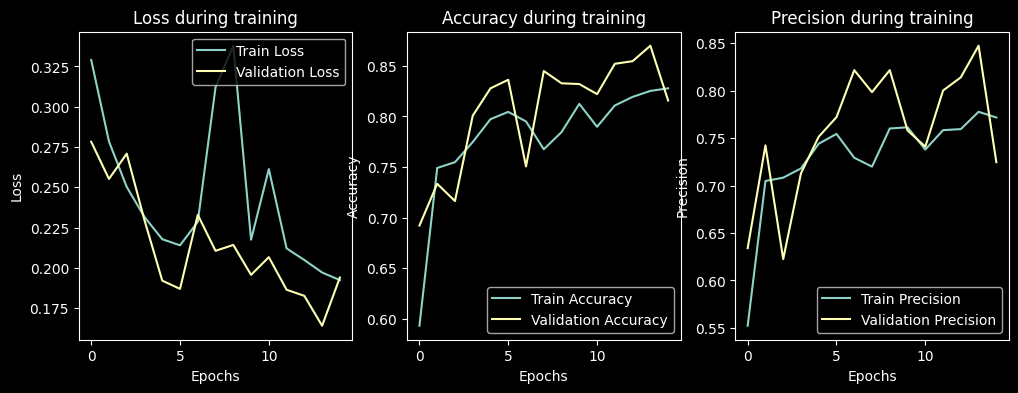

In [19]:
# График потерь
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# График точности
plt.subplot(1, 3, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision during training')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.show()

In [20]:
# Предсказание на валидационных данных
Y_pred_unet = model_unet.predict(X_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 12s/step


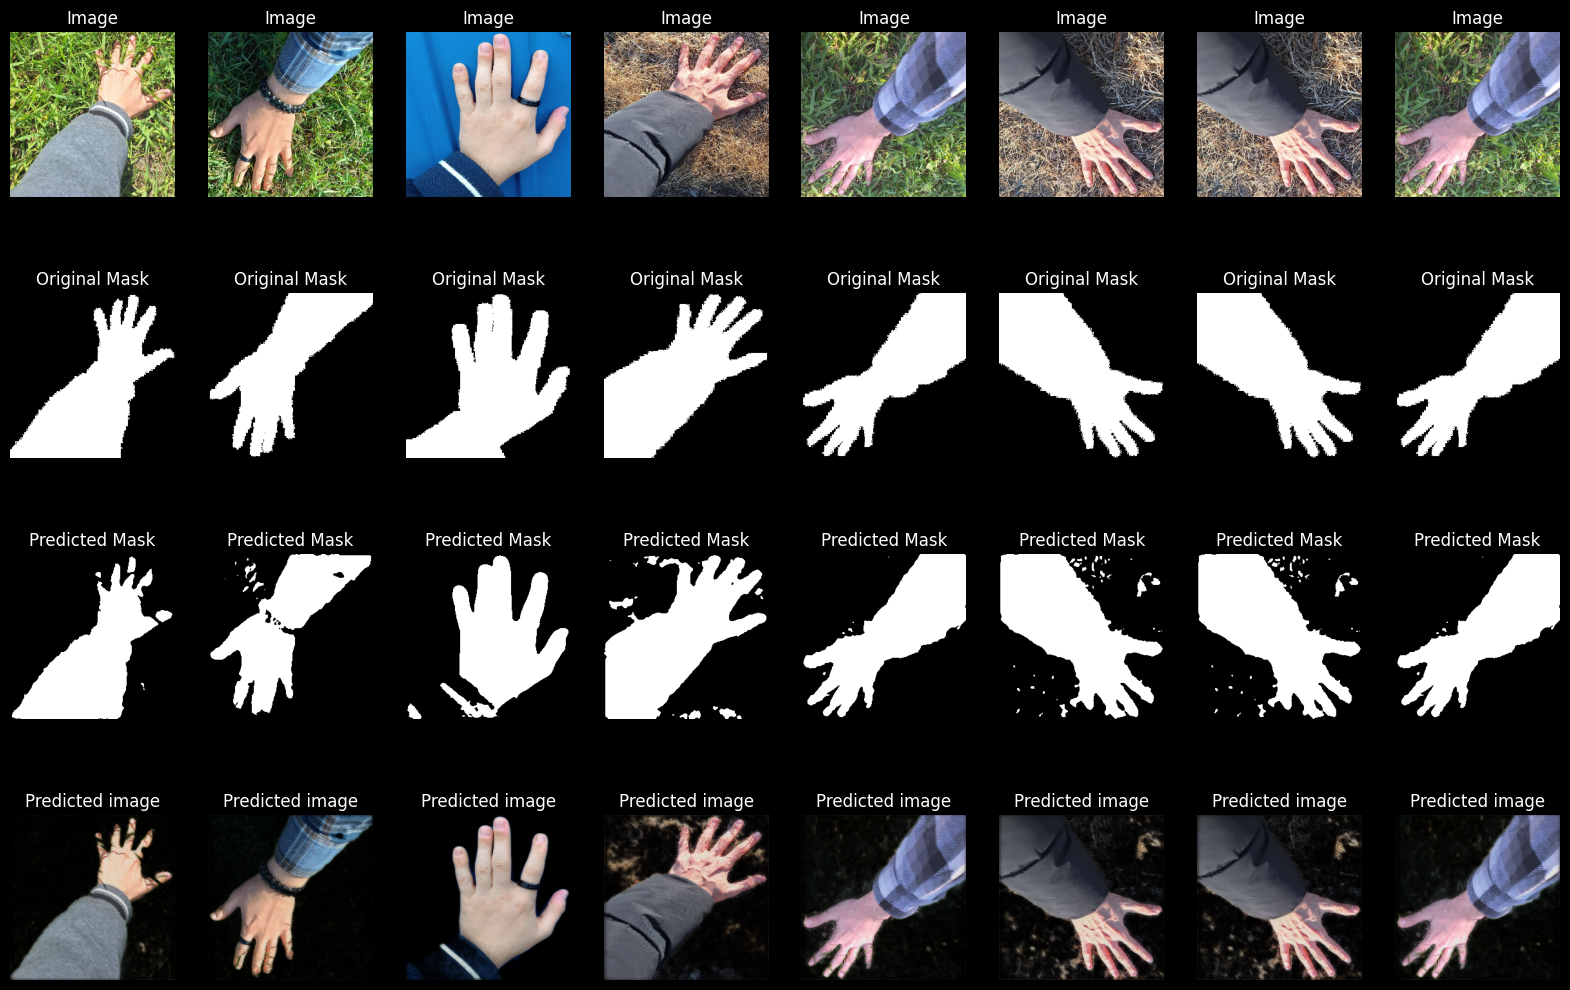

In [27]:
plot_results(X_val, Y_val, Y_pred_unet, num=8)

In [28]:
Y_pred = (Y_pred_unet > 0.5).astype(np.float32)
# Вычисление метрик
accuracy = np.mean(Y_pred.flatten() == Y_val.flatten())
precision = precision_score(Y_val.flatten(), Y_pred.flatten())
recall = recall_score(Y_val.flatten(), Y_pred.flatten())

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Accuracy: 0.8158, Precision: 0.7247, Recall: 0.9618


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


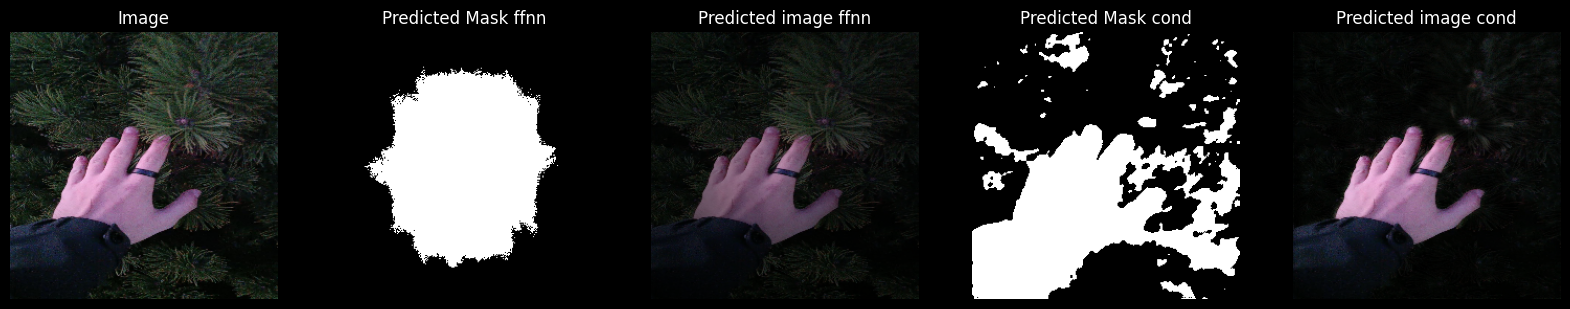

In [32]:
img = load_image('touching_test/3.jpg')
mask1 = model_fc.predict(img)[0]
mask2 = model_unet.predict(img)[0]
plot_result(img, mask1, mask2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


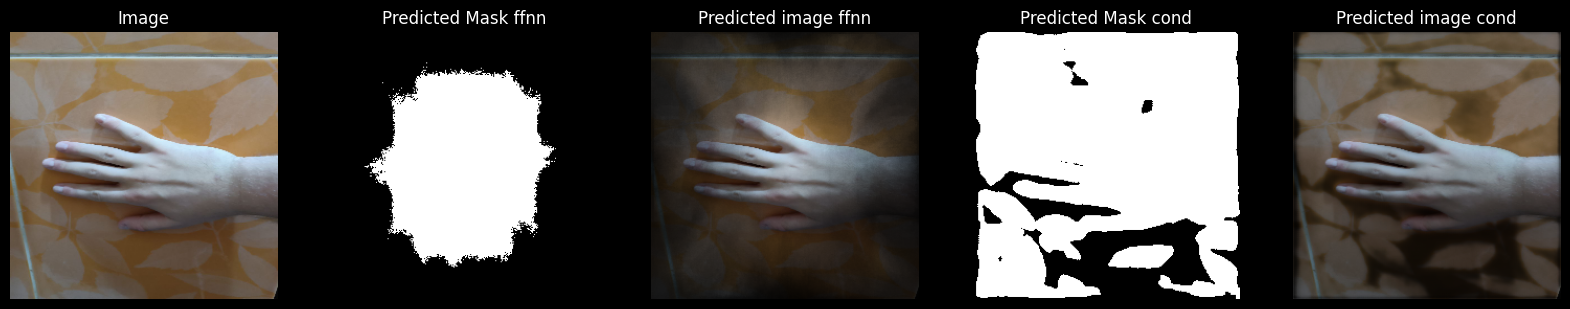

In [31]:
img = load_image('touching_test/2.jpg')
mask1 = model_fc.predict(img)[0]
mask2 = model_unet.predict(img)[0]
plot_result(img, mask1, mask2)